In [1]:
import h5py
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
import os

def datx2py(file_name):
    """Loads a .datx into Python, credit goes to gkaplan.
    https://gist.github.com/g-s-k/ccffb1e84df065a690e554f4b40cfd3a"""
    def _group2dict(obj):
        return {k: _decode_h5(v) for k, v in zip(obj.keys(), obj.values())}
    def _struct2dict(obj):
        names = obj.dtype.names
        return [dict(zip(names, _decode_h5(record))) for record in obj]
    def _decode_h5(obj):
        if isinstance(obj, h5py.Group):
            d = _group2dict(obj)
            if len(obj.attrs):
                d['attrs'] = _decode_h5(obj.attrs)
            return d
        elif isinstance(obj, h5py.AttributeManager):
            return _group2dict(obj)
        elif isinstance(obj, h5py.Dataset):
            d = {'attrs': _decode_h5(obj.attrs)}
            try:
                d['vals'] = obj[()]
            except (OSError, TypeError):
                pass
            return d
        elif isinstance(obj, np.ndarray):
            if np.issubdtype(obj.dtype, np.number) and obj.shape == (1,):
                return obj[0]
            elif obj.dtype == 'object':
                return _decode_h5([_decode_h5(o) for o in obj])
            elif np.issubdtype(obj.dtype, np.void):
                return _decode_h5(_struct2dict(obj))
            else:
                return obj
        elif isinstance(obj, np.void):
            return _decode_h5([_decode_h5(o) for o in obj])
        elif isinstance(obj, bytes):
            return obj.decode()
        elif isinstance(obj, list) or isinstance(obj, tuple):
            if len(obj) == 1:
                return obj[0]
            else:
                return obj
        else:
            return obj
    with h5py.File(file_name, 'r') as f:
        h5data = _decode_h5(f)
    return h5data

def get_data(datx_file):
    """Returns the Surface and Intensity data from a single .datx file"""
    myh5 = datx2py(datx_file)                      # File is the string with the location of the file
    zsurf = myh5['Data']['Surface']           # Get the surfaces
    zdata = list(zsurf.values())[0]           # Good for fixing stuff later  
    zsurf = zdata['vals']                     # Get the data from the surface group
    zsurf[zsurf == zdata['attrs']['No Data']] = np.nan  # Write no data as NaNs for compatibility
    zint = myh5['Data']['Intensity']          # Get the intensity group
    zint = list(zint.values())[0]['vals'].astype(float)  # Get the data from the intensity grou[]
    zint[zint>200000] = np.nan                # This fixes the regions left out from stitching
    return zsurf, zint
    
def getcleansurf(img):
    suma = np.nansum(img, axis=0)
    counts = np.sum(~np.isnan(img), axis=0)
    counts[counts<20] = 0
    f = suma/counts
    f[np.isinf(f)] = np.nan
    return f

def find_edge(y, v):
    g2 = np.abs(np.gradient(y))
    idx = np.argwhere(g2>v)
    l = idx[0][0]
    h = idx[-1][0]
    return l,h

def subline(f, offx, offy):
    xchange = -len(f)
    ychange = (f[0]-offx)-(f[-1]-offy)
    xarray = np.arange(len(f))
    yarray = xarray*(ychange/xchange) + (f[0]-offx)
    res = (f-yarray)
    return res

def plot_bounds(i, C, l):
    plt.figure(figsize=(7, 5))
    plt.subplot(211)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.subplot(223)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,0]-l, C[i,0]+l)
    plt.subplot(224)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,1]-l, C[i,1]+l)
    plt.tight_layout()
    
def plotrel_profile(i, C, o):
    plt.figure(figsize=(14, 5))
    s_past = subline(first_pass[i-1][C[i-1,0]:C[i-1,1]]/1e3, o[i-1,0], o[i-1,1])
    s_curr = subline(first_pass[i][C[i,0]:C[i,1]]/1e3, o[i,0], o[i,1])
    s_futu = subline(first_pass[i+1][C[i+1,0]:C[i+1,1]]/1e3, o[i+1,0], o[i+1,1])

    plt.plot(s_past, label="Past")
    plt.plot(s_curr, label="Current")
    plt.plot(s_futu, label="Future")
    plt.axhline(np.nanmax(s_curr), color="black", linestyle="--")
    plt.axhline(0, color="black", linestyle="--")
    plt.legend()

def shift(n_s, f):
    start[n_s:] += f*np.arange(n-n_s)

In [175]:
# Load TIMELAPSE files and get times

folder = "/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/additional_data/Column growth/2022-05-06_columns/"
files = glob(folder+"Raw/*.datx")                                           # Folder with all the .datx
files.sort()
files_split = [files[0:21], files[21:42], files[42:63]]     # Long growth
files_split = [files[0:36], files[36:72]]
tstart = 1651873000.0
times = np.zeros([2, 36])
n = 21   
C = np.zeros([36, 2]) 
offsets = np.zeros([36,2])
for i in range(2):
    for j in range(36):
        times[i,j] = (os.path.getmtime(files_split[i][j])-tstart)/3600
print(times)
np.save(folder+"Clean/times.npy", times)


[[ 47.29111111  94.42333333 142.84666667  47.34055556  94.48
  142.91111111  47.39555556  94.53666667 142.98666667  47.44555556
   94.64277778 143.05833333  47.57944444  94.76166667 143.15555556
   47.61888889  94.82055556 143.22944444  47.66222222  94.88833333
  143.30333333  47.70333333  94.94333333 143.37611111  47.77166667
   95.01611111 143.46611111  47.84777778  95.08611111 143.53277778
   47.88277778  95.22888889 143.60944444  47.92277778  95.3
  143.69444444]
 [ 46.40777778  95.36944444 143.80611111  46.5         95.42444444
  143.88166667  46.54388889  95.48166667 143.97388889  46.70388889
   95.53833333 144.02777778  46.76888889  95.61277778 144.13833333
   46.81888889  95.65388889 144.20388889  46.86611111  95.70388889
  144.27722222  46.90888889  95.74833333 144.31944444  47.05777778
   95.81111111 144.43277778  47.10333333  95.85666667 144.59222222
   47.14888889  95.90222222 144.63833333  47.20055556  95.94555556
  144.68277778]]


In [30]:
len(files_split[1])

36

## 1. Biofilm edges

In this step we find the left `l` and right `r` edges in the biofilm profile, we use the function `find_edge(profile)`, which will automatically find them for us. Since experimental data is subject to the Zygo stitching algorithm, the algorithm *may* fail, adjusting the edge location **should** be done before the other steps. 
`l` and `r` and then stored in an Array containing all the edge locations `C`.
For this we first lower the dimensionality of all the timelapse `j` into a list of profiles called `first_pass`. That way when we call them individually and plot against each other they are ready to plot.

Then, we loop over the indivdual profiles `i` while also plotting the previous `i-1` and future `i+1` timesteps. We start from a base offset of 0, that should output the relative height of the profiles in relation to the 

In [176]:
# Load the timelapse here with j
first_pass = []
j = 1                                     # Which of the replicates we'll be working on
for i in range(36):
    s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    first_pass.append(s)
    lim_edge = 150
    l, r = find_edge(s,lim_edge)                      # Here, 15 is the detection threshold
    C[i] = np.array([l,r])
    print(i, end="\r")

/tmp/ipykernel_9566/2109317321.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_9566/2109317321.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


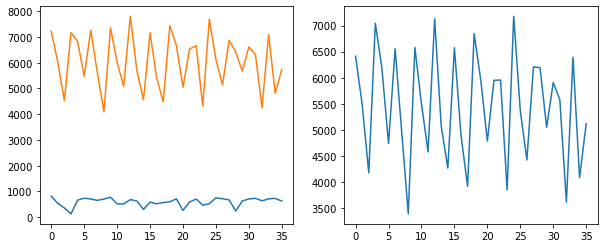

In [177]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(C[:,:])
plt.subplot(122)
plt.plot(C[:,1]-C[:,0])

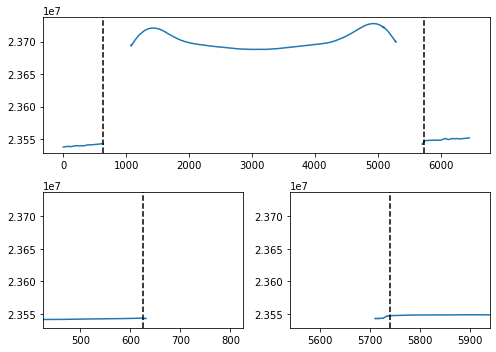

In [243]:
# Here we loop over each profile
i = 35
C[i,0] += 0
C[i,1] += 0
plot_bounds(i, C, 200)

In [244]:
np.save(folder+"Clean/bounds_B.npy", C)


## 2. Leveling the profiles

This is the slowest part, since it involves looking at 3 consecutive profiles, and correcting for height displacements. For *most* of the timelapse, you should aim to have the <span style="color:#FF7F0E">**current**</span> profile between the <span style="color:#1F77B4">**past** </span> and <span style="color:#2CA02C">**future**</span> ones.
While some particular timepoints are off just because of small miscalculations in finding the edges, more prevalent issues may arise when the actual biofilm-lb border goes out of focus in either the in or out of plane direction. This will lead to a few consecutive offsets in the same side of the sample.


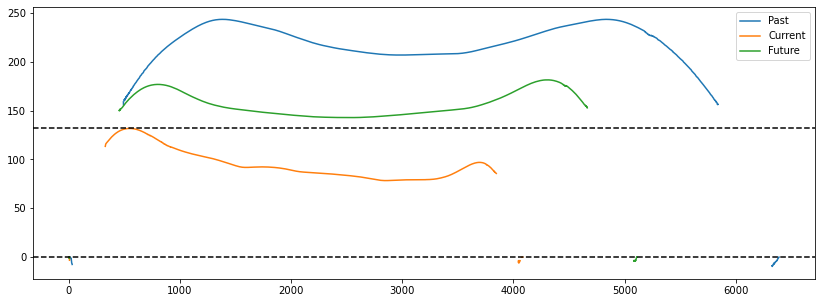

In [294]:
##
i = 34
#offsets[0,1] += 0.5
offsets[i,0] += 0.0
offsets[i,1] += 0.0
plotrel_profile(i, C, offsets)
#plt.ylim(170, 200)

In [295]:
np.save(folder+"Clean/offsets_B.npy", offsets)
np.save(folder+"Clean/bounds_B.npy", C)


In [251]:
C = C.astype(int)

## 3. Displacement alignment

Now we have a set of profile heights that correspond to the same timelapse. Since we work using the center of the colonies, it would be useful to have everything aligned, so we can get the data quickly.

Of course, the size of the first inoculum is much less than the final point. For this, we center everything into a 2D array with ALL the timelapse profiles.

In [305]:
offnames = [folder+"Clean/offsets_A.npy", folder+"Clean/offsets_B.npy", folder+"Clean/offsets_C.npy"]
Cnames = [folder+"Clean/bounds_A.npy", folder+"Clean/bounds_B.npy", folder+"Clean/bounds_C.npy"]
dnames = [folder+"Clean/displacement_A.npy", folder+"Clean/displacement_B.npy", folder+"Clean/displacement_C.npy"]


# For timelapses
j = 0                                          # Which of the replicates we'll be working on
n = 36
offsets = np.load(offnames[j])
C = np.load(Cnames[j]).astype(int)
data = []                                 # We'll do a naive detection of the edges
for i in range(n):
    s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    s_curr = subline(s[C[i,0]:C[i,1]]/1e3, offsets[i,0], offsets[i,1]) # Use edges and offsets to subtract
    data.append(s_curr)

/tmp/ipykernel_9566/2109317321.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_9566/2109317321.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


In [306]:
S = np.array([len(x) for x in data])
np.max(S)

9147

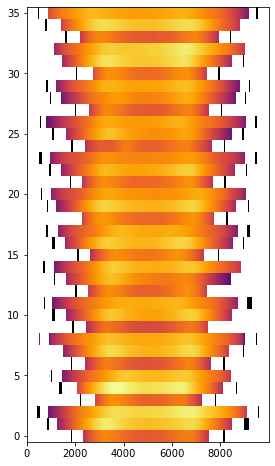

In [307]:
L = 10000
IMG = np.zeros([len(data), L])
IMG[:] = np.nan

start = (L-S)/2
start = start.astype(int)
#shift(47, 25)
#shift(80, 70)
#shift(90, 40)
#start[64] += 1200
#start[65] += 2600
#start[66] += 2600

for i in range(len(data)):
    IMG[i, start[i]:len(data[i])+start[i]] = data[i]
plt.figure(figsize=(8,8))
plt.imshow(IMG, aspect=500, clim=(0, 350), origin="lower", cmap="inferno", interpolation="none")

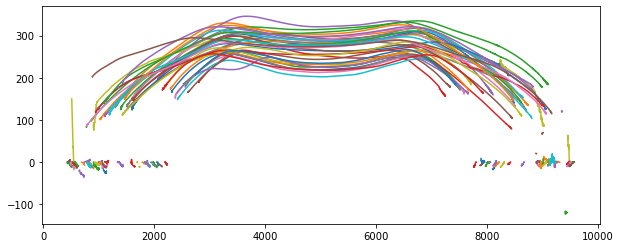

In [308]:
k = 0
k_sp = 36
plt.figure(figsize=(10, 4))
plt.plot(np.transpose(IMG[k:k+k_sp,:]));

In [309]:
np.save(folder+"Clean/bounds_A.npy", C)
np.save(folder+"Clean/offsets_A.npy", offsets)
np.save(folder+"Clean/profiles_A.npy", IMG)
np.save(folder+"Clean/displacement_A.npy", start)

## 4. Save everything into a .csv

Now we have all the required building blocks for our .csv, for each of [A, B, C, control]:
1. Profiles
2. Boundaries
3. Offset
4. Displacement

Now we load everything into a simple panda dataframe, and export it as .csv!

In [4]:
import pandas as pd
df = pd.DataFrame({'file':[], 'replicate':[], 'time':[], 'border_l':[], 'border_r':[], 'offset_l':[], 'offset_r':[], 'displacement':[]})
offnames = [folder+"Clean/offsets_A.npy", folder+"Clean/offsets_B.npy", folder+"Clean/offsets_C.npy"]
Cnames = [folder+"Clean/bounds_A.npy", folder+"Clean/bounds_B.npy", folder+"Clean/bounds_C.npy"]
dnames = [folder+"Clean/displacement_A.npy", folder+"Clean/displacement_B.npy", folder+"Clean/displacement_C.npy"]

replicate = ["A", "B", "C"]
times = np.load(folder+"Clean/times.npy")

In [6]:
# Loop over ABC
for j in range(3):
    offsets = np.load(offnames[j])
    C = np.load(Cnames[j])
    displ = np.load(dnames[j])
    t = times[j,:]
    repl = np.repeat(replicate[j], len(t))
    fnames = [name[len(folder)+4:] for name in files_split[j]]
    b_l, b_r = C[:,0], C[:,1]
    o_l, o_r = offsets[:,0], offsets[:,1]
    tf = pd.DataFrame({'file':fnames, 'replicate':repl, 'time':t, 'border_l':b_l, 'border_r':b_r, 'offset_l':o_l, 'offset_r':o_r, 'displacement':displ})
    df = df.append(tf)
df.to_csv(folder+"Clean/cleaning.csv", index=False) 


In [301]:
h_avg = np.mean(IMG[:, 2500:4500], axis=1)

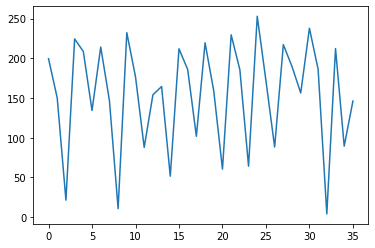

In [302]:
plt.plot(h_avg)

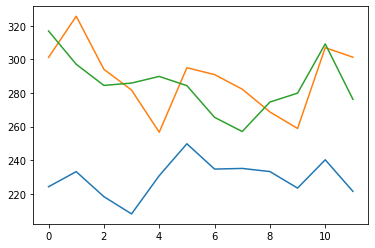

In [159]:
plt.plot(np.reshape(h_avg, (12, 3)))

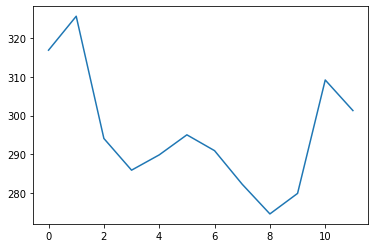

In [168]:
plt.plot(np.max(np.reshape(h_avg, (12, 3)), axis=1))

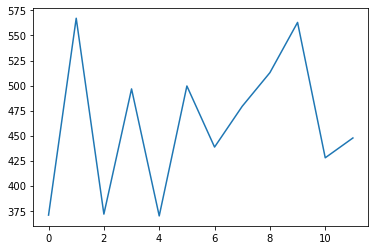

In [304]:
plt.plot(np.sum(np.reshape(h_avg, (12, 3)), axis=1))